<a href="https://colab.research.google.com/github/lokasenna9312/AIFFEL_quest_cr/blob/main/AIFFEL_quest_cr/MainQuest%20/Quest03/20250223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 라이브러리 소환

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 코랩 드라이브 마운팅

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 분석 자료 받기

import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [4]:
os.getenv('HOME')

'/root'

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), '.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2')
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 기계학습 과정 관련 하이퍼파라미터
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [6]:
# 휸련, 테스트, 검증 파일이 몇 개씩인지 세보기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
# train 데이터 안의 정상 이미지 경로와 폐렴 이미지 경로를 보기

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0400-0001.jpeg
Pneumonia image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person387_virus_772.jpeg


In [9]:
# 파일들의 경로를 분석하여 정상 이미지 수와 폐렴 이미지 수를 세보기

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [10]:
# tf.data 인스턴스 만들어 보기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# train, validation 데이터셋 갯수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하여 정상 이미지와 폐렴 이미지를 구분하는 함수를 만들기
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == "PNEUMONIA" :
        return 1   # 폐렴이면 양성(1)
    else :
        return 0   # 노말이면 음성(0)

In [13]:
# 이미지를 알맞은 형식으로 변환하는 함수 생성
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오는 함수 생성
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
# train, validation 데이터셋 만들기

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# 이미지와 라벨 처리가 잘 되었는지 확인하기

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [16]:
#test 데이터셋을 만들고 데이터 갯수 확인하기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
# tf.data 파이프라인 생성

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

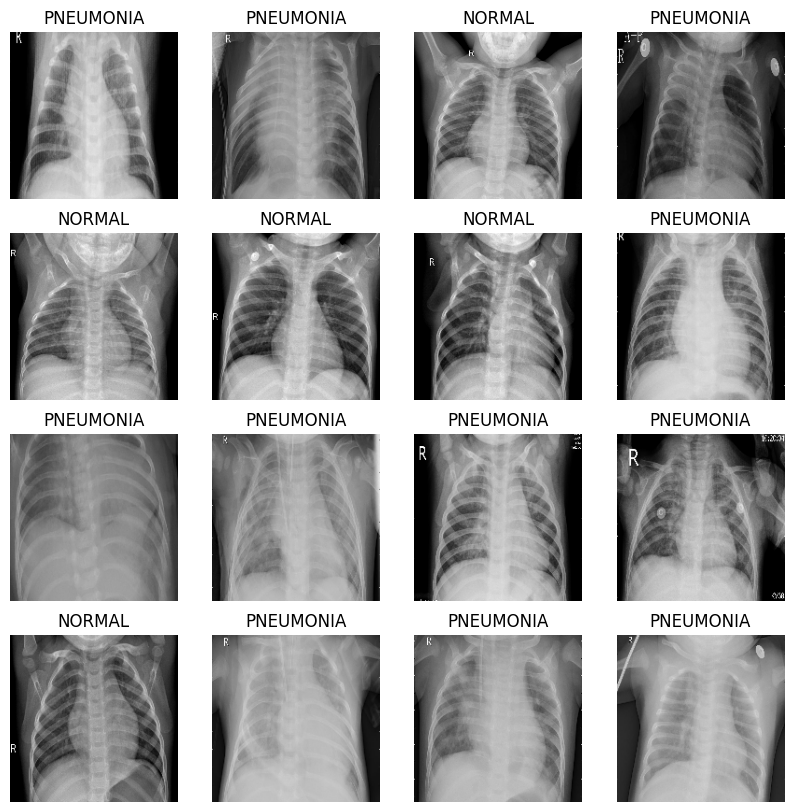

In [18]:
# 첫 번째 batch의 이미지 보기
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [19]:
# Convolution Block 만들기

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [20]:
# Dense Layer Block 만들기

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [21]:
# 훈련 모델 만들기

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [22]:
# Weight Balancing

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [23]:
#모델 컴파일

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
# 실제 훈련

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 289ms/step - accuracy: 0.7038 - loss: 0.5551 - precision: 0.9050 - recall: 0.6695 - val_accuracy: 0.7356 - val_loss: 0.6411 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 307ms/step - accuracy: 0.8994 - loss: 0.2622 - precision: 0.9714 - recall: 0.8906 - val_accuracy: 0.7337 - val_loss: 1.2839 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 83s 317ms/step - accuracy: 0.9182 - loss: 0.2087 - precision: 0.9777 - recall: 0.9116 - val_accuracy: 0.7942 - val_loss: 0.4625 - val_precision: 0.9877 - val_recall: 0.7301
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 316ms/step - accuracy: 0.9147 - loss: 0.2078 - precision: 0.9729 - recall: 0.9112 - val_accuracy: 0.9596 - val_loss: 0.1125 - val_precision: 0.9918 - val_recall: 0.9529
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.9296 - loss: 0.1786 - precision: 0.9793 - recall: 0.9251 - val_accuracy: 0.974

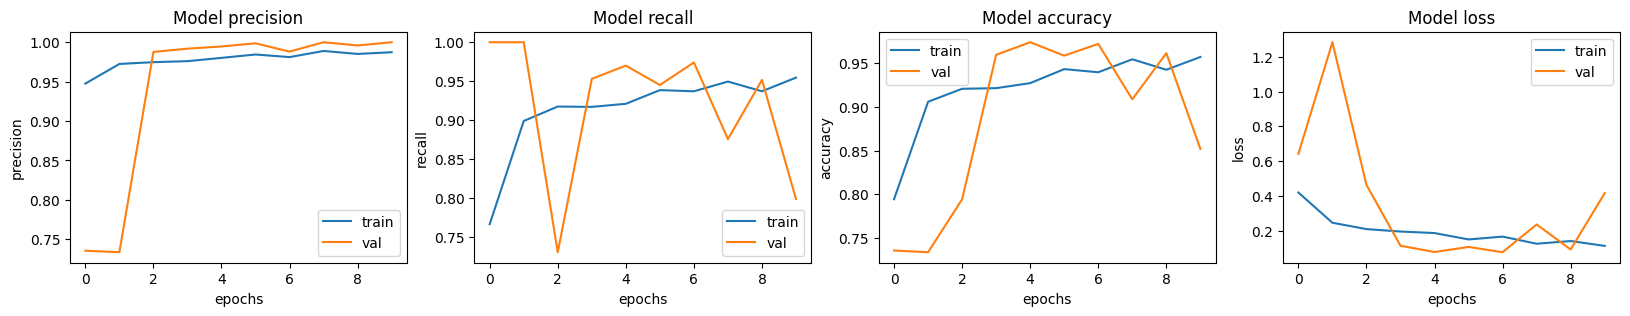

In [25]:
# 매 Epoch마다 모델 평가

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
# 모델 전체 평가

precision, recall, accuracy, loss = model.evaluate(test_ds)
print(f'Precision: {precision},\nRecall: {recall},\nAccuracy: {accuracy},\nLoss: {loss}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8864 - loss: 0.3801 - precision: 0.9401 - recall: 0.8751
Precision: 0.3828166425228119,
Recall: 0.8782051205635071,
Accuracy: 0.9410112500190735,
Loss: 0.8589743375778198


In [30]:
'''
Precision는 0.38로 꽤 낮은 값을 보였지만, Loss가 0.85로 높지 않은 값을 보였다.
하지만 전체 평가에서의 Loss는 0.85이라는 값을 보였는데 각 epoch에서의 Loss는 3번째 Epoch부터 일관적으로 0.2 이하의 값을 보이는 것이 의문이다.
'''

'\nPrecision는 0.38로 꽤 낮은 값을 보였지만, Loss가 0.85로 높지 않은 값을 보였다.\n하지만 전체 평가에서의 Loss는 0.85이라는 값을 보였는데 각 epoch에서의 Loss는 3번째 Epoch부터 일관적으로 0.2 이하의 값을 보이는 것이 의문이다.\n'

In [31]:
# 주어진 사진들을 이용해서 훈련 데이터를 더 많이 생성하는 레이어 만들기

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_preprocessing_v1():
    model = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.2),

        layers.Normalization(),
    ])

    model.name = "image_preprocessing_v1"

    return model

def image_preprocessing_v2():
    model = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.2),

        layers.BatchNormalization(),
    ])

    model.name = "image_preprocessing_v2"

    return model

In [41]:
# 위의 레이어를 모델에 직접 적용

import tensorflow, keras
from keras import layers

def build_model_with_augmentator():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        image_preprocessing_v1(),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [42]:
#모델 컴파일

with tf.device('/GPU:0'):
    model_with_augmentator = build_model_with_augmentator()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model_with_augmentator.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:
# 실제 훈련

with tf.device('/GPU:0'):
    history = model_with_augmentator.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 104s 296ms/step - accuracy: 0.6520 - loss: 0.6797 - precision: 0.8686 - recall: 0.6203 - val_accuracy: 0.7356 - val_loss: 0.5806 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 81s 311ms/step - accuracy: 0.7864 - loss: 0.4627 - precision: 0.9307 - recall: 0.7729 - val_accuracy: 0.7356 - val_loss: 0.9580 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 309ms/step - accuracy: 0.8288 - loss: 0.3939 - precision: 0.9532 - recall: 0.8104 - val_accuracy: 0.8173 - val_loss: 0.3339 - val_precision: 0.8049 - val_recall: 0.9922
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 313ms/step - accuracy: 0.8457 - loss: 0.3446 - precision: 0.9632 - recall: 0.8243 - val_accuracy: 0.9221 - val_loss: 0.2111 - val_precision: 0.9899 - val_recall: 0.9030
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 84s 321ms/step - accuracy: 0.8510 - loss: 0.3403 - precision: 0.9592 - recall: 0.8361 - val_accuracy: 0.923

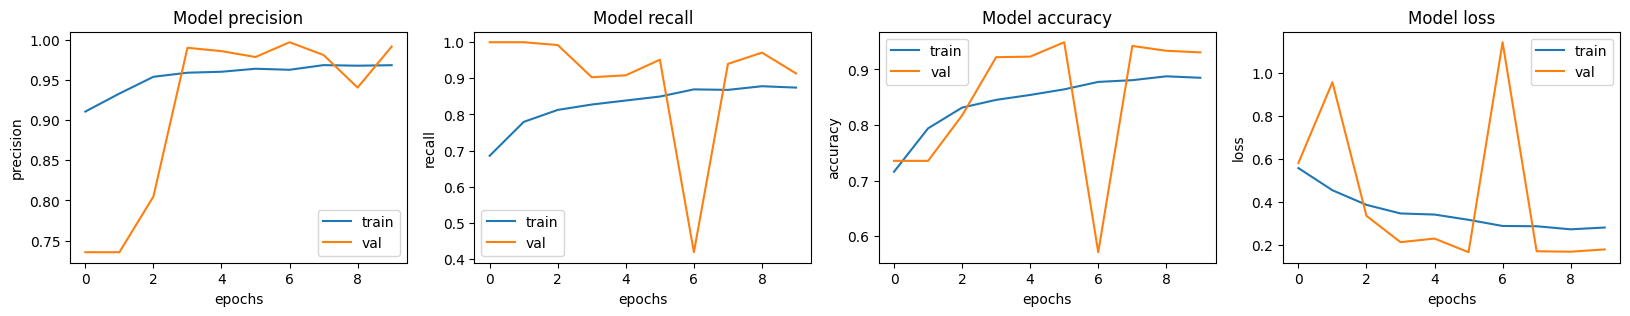

In [44]:
# 매 Epoch마다 모델 평가

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
# 모델 전체 평가

precision, recall, accuracy, loss = model.evaluate(test_ds)
print(f'Precision: {precision},\nRecall: {recall},\nAccuracy: {accuracy},\nLoss: {loss}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.8711 - loss: 0.4088 - precision: 0.9676 - recall: 0.8313
Precision: 0.3828166425228119,
Recall: 0.8782051205635071,
Accuracy: 0.9410112500190735,
Loss: 0.8589743375778198


In [ ]:
'''
Precision는 0.38로 오히려 떨어졌지만, Loss가 0.85로 많이 떨어졌다.
하지만 각 epoch에서의 Loss는 데이터를 증강하기 전보다 오히려 더 높아졌다.
'''